#DATOS DE MERCADEO DE VALORES (Acciones de XXXXX)

---
Vamos a aplicar el algoritmo sobre un conjunto de datos de las acciones de XXX en bolsa de Estados unidos, donde bucaremos :


*   la señal CLOSE (precio de cierre diario) 
*   la señal VOLUME (número de acciones que han cambiado de manos a lo largo de dicho período de tiempo).


https://es-us.finanzas.yahoo.com/


##Importando librerías generales

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing  #para normalizar los datos antes de aplicar al algoritmo
from sklearn.metrics import pairwise_distances_argmin_min

import matplotlib.pyplot as plt
import seaborn as sb
from mpl_toolkits.mplot3d import Axes3D

#configuraciones basicas para PLT
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

##Descargando data usando Web-scrawping

###Consumiendo data (web scraping) 

In [ ]:
#UrlWeb="https://es.wikipedia.org/wiki/Departamentos_de_Colombia"
#ClassName="wikitable sortable jquery-tablesorter"
UrlWeb= "https://es-us.finanzas.yahoo.com/quote/005930.KS/history?period1=1578009600&period2=1648166400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"    #Acciones MercadoLibre inc. (MELI)
ClassName="W(100%) M(0)"                                                               #clase de la tabla 

####Op1-con BeautifulSoup

In [ ]:
import requests                           # libreria para manejar pedidos internet
from bs4 import BeautifulSoup             # libreria para parsear documentos HTML

In [ ]:
response=requests.get(UrlWeb)                                        # hacemos un request(petición)a la pagina
print(response.status_code)
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')                    # parceamos el texto htmlt
tabla= soup.find_all(class_=ClassName)
df_list_table=pd.read_html(str(tabla))                                      # LEEMOS el THEAD y TBODY y lo guardamos en una lista
dfs=pd.DataFrame(df_list_table[0])                                        # convertimos la lista en un dataframe
df.to_csv('dataAcciones.csv', index_label='row')
df.head()

####Opt2-con Selenium (cuando bloquean las páginas para robots)

---
A diferencia de Scrapy y de BeautifulSoup, Selenium no trabaja con el texto fuente en HTML de la web en cuestión, sino que carga la página en un navegador sin interfaz de usuario que crea un DOM ( Document Object Model-modelo de objetos de documento). En este navegador se puede simular clic's 
*   URL → Solicitud HTTP → HTML → Selenium → DOM


In [ ]:
!pip install kora -q
!apt install chromium-chromedriver
!pip install selenium

In [ ]:
from kora.selenium import wd
wd.get(UrlWeb)
soup = BeautifulSoup(wd.page_source, 'html.parser') 

In [ ]:
tabla= soup.find_all(class_=ClassName)
df_list_table=pd.read_html(str(tabla))                                      # LEEMOS el THEAD y TBODY y lo guardamos en una lista
df=pd.DataFrame(df_list_table[0])                                        # convertimos la lista en un dataframe

In [ ]:
#df.head(10)                                                       #LAS PRIMERAS FILAS
df.tail(100)                                                         #Las ultimas filas

In [ ]:
#tenemosque borrar la ultima fila
df = df[:-1]

##Conociendo los datos descargados

In [ ]:
print(df.info())
print("____________describe____________\n",df.describe())
print("____________nulos?____________\n",df.isnull().sum())
#print("Rows, Cols->",df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Fecha              100 non-null    object
 1   Abrir              100 non-null    object
 2   Alto               100 non-null    object
 3   Bajo               100 non-null    object
 4   Cierre*            100 non-null    object
 5   Cierre ajustado**  100 non-null    object
 6   Volumen            100 non-null    object
dtypes: object(7)
memory usage: 5.6+ KB
None
____________describe____________
               Fecha    Abrir     Alto     Bajo  Cierre* Cierre ajustado**  \
count           100      100      100      100      100               100   
unique           99       99       99       99       99                99   
top     18 mar 2022  1133.28  1191.47  1120.51  1185.53           1185.53   
freq              2        2        2        2        2                 2   

       Vo

###Normalización de los datos.

---
Como ocurre con cualquier algoritmo de Machine Learning que utilice funciones de distancia, los datos deben ser normalizados antes de aplicarles el algoritmo:
*   conversión de datos de object a int/float o dateime
*   eliminar campos que no usaremos
*   En este caso utilizaremos la función MinMaxScaler() que normaliza todos los datos entre [0, 1].


####Convertimos los campos object a datetime o numeric (int/float)

In [ ]:
df['Fecha']= df['Fecha'].str.replace(' ene ','/01/')
df['Fecha']= df['Fecha'].str.replace(' feb ','/02/')
df['Fecha']= df['Fecha'].str.replace(' mar ','/03/')
df['Fecha']= df['Fecha'].str.replace(' abr ','/04/')
df['Fecha']= df['Fecha'].str.replace(' may ','/05/')
df['Fecha']= df['Fecha'].str.replace(' jun ','/06/')
df['Fecha']= df['Fecha'].str.replace(' jul ','/07/')
df['Fecha']= df['Fecha'].str.replace(' ago ','/08/')
df['Fecha']= df['Fecha'].str.replace(' sep ','/09/')
df['Fecha']= df['Fecha'].str.replace(' oct ','/10/')
df['Fecha']= df['Fecha'].str.replace(' nov ','/11/')
df['Fecha']= df['Fecha'].str.replace(' dic ','/12/')

In [ ]:
df['Fecha']=pd.to_datetime(df['Fecha'], dayfirst = True)        # Convertimos el campo FECHA en tipo DATETIME
df['Abrir'] = pd.to_numeric(df['Abrir'])                        #  convertimos el campo a numerico 
df['Alto'] = pd.to_numeric(df['Alto'])
df['Bajo'] = pd.to_numeric(df['Bajo'])
df['Cierre*'] = pd.to_numeric(df['Cierre*'])
df['Cierre ajustado**'] = pd.to_numeric(df['Cierre ajustado**'])
df['Volumen'] = pd.to_numeric(df['Volumen'])

In [ ]:
#salvamos el dataFrame 
df.to_csv('Precio_petroleo_2021_2022.csv', index_label='row')

####Eliminando columnas que no necesitaremos (por ahora)

---
extraemos la columna DATE (fecha) que no usaremos en el algoritmo k-means. Antes de extraerla la guardaremos en la variable dates, ya que volveremos a insertarla en nuestro dataframe tras aplicar el algoritmo


In [ ]:
#borrar nulos o no?
df = df.dropna()
df = df.reset_index(drop=True)

In [ ]:
# Eliminamos columna de fecha que no usaremos en el algoritmo.
dates = df['Fecha'] # Guardamos la columna Date.
df = df.drop('Fecha', 1) # Borramos la columna del dataframe.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


####normaliza todos los datos entre [0, 1].

---
En este caso utilizaremos la función MinMaxScaler()


In [ ]:
#%% Se normalizan los datos con MinMax()
min_max_scaler = preprocessing.MinMaxScaler() 
df_escalado = min_max_scaler.fit_transform(df)
df_escalado = pd.DataFrame(df_escalado) # Hay que convertir a DF el resultado.
df_escalado = df_escalado.rename(columns = {0:'Abrir',1:'Alto',2:'Bajo',3:'Cierre*',4: 'Cierre ajustado**', 5: 'Volumen'})

In [ ]:
df_escalado.head()
#df_escalado.isnull().sum()

,Abrir,Alto,Bajo,Cierre*,Cierre ajustado**,Volumen
0,0.328888,0.336072,0.326431,0.366231,0.366231,0.304918
1,0.328888,0.336072,0.326431,0.366231,0.366231,0.316617
2,0.250466,0.283615,0.233090,0.322196,0.322196,0.279995
3,0.138104,0.188693,0.145778,0.233834,0.233834,0.378953
4,0.027073,0.033545,0.031243,0.084434,0.084434,0.194808


###Representación gráfica de los datos.

---


*   Ahora podemos echar un vistazo a la representación gráfica de nuestros datos. En el eje x representaremos el precio de cierre (CLOSE) y en el eje y el volumen (VOLUMEN)
*   VAMOS A representar gráficamente los datos normalizados, pero que, si hubiésemos representado los datos sin normalizar la gráfica sería exactamente igual, con la única diferencia que la escala de los ejes sería diferente.





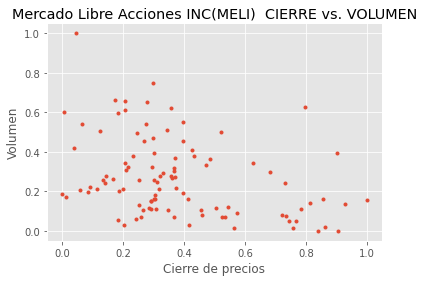

In [ ]:
#%% Representación gráfica de los datos.
x = df_escalado['Cierre*'].values
y = df_escalado['Volumen'].values
plt.xlabel('Cierre de precios')
plt.ylabel('Volumen')
plt.title('Mercado Libre Acciones INC(MELI)  CIERRE vs. VOLUMEN')
plt.plot(x,y,'o',markersize=3)

##Aplicación de k-means.

---
El primer paso antes de aplicar k-means es decidir qué valor de k (número de clústeres) queremos usar:


1.    Una forma de elegir este valor k es por criterio propio: si conocemos bien la distribución de nuestros datos y queremos “forzar” un número determinado de clústeres simplemente lo elegimos
2.    realizar una gráfica elbow o de codo para determinar el número óptimo de clústeres. Hacemos una iteración de k-means variando el valor de k, de forma que representamos en el eje x dicho valor de k y en el eje y la suma de los errores cuadráticos (SSE). De esta forma podemos elegir el valor de k dónde se produce el “codo”   (**----ESTA ME GUSTA MÁS---**)




###Realizar una gráfica elbow o de codo

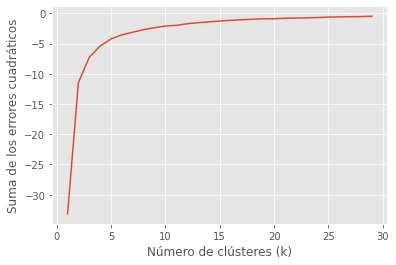

In [ ]:
#%% Curva elbow para determinar valor óptimo de k.
nc = range(1, 30) # El número de iteraciones que queremos hacer.
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(df_escalado).score(df_escalado) for i in range(len(kmeans))]
score
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(nc,score)

####NOTA: 

---


**No hay una solución, un valor de k, más correcto que otro**, ya que el objetivo de una clusterización con k-means es obtener información útil nuestros datos, por lo que **nuestra interpretación a posteriori de los clústeres creados marcará la calidad de nuestra solución** escogida

###Aplicar el algoritmo de k-mean

In [ ]:
#%% Aplicación de k-means con k = 5.
kmeans = KMeans(n_clusters=5).fit(df_escalado)
centroids = kmeans.cluster_centers_
print(centroids)   #coordenadas de los centroides

[[0.85069666 0.83863332 0.84059312 0.81371471 0.81371471 0.150878  ]
 [0.33514412 0.31590686 0.30940401 0.31330607 0.31330607 0.26489967]
 [0.18419459 0.16065865 0.13720277 0.16945799 0.16945799 0.64693304]
 [0.55105749 0.51974851 0.52562774 0.502605   0.502605   0.20138525]
 [0.16185391 0.12736809 0.12587374 0.12442901 0.12442901 0.22108647]]


###Etiquetado de datos.

---
asignamos cada registro de nuestro dataset a uno de los clústers


In [ ]:
#%% Etiquetamos nuestro dataframe.
labels = kmeans.predict(df_escalado)   #generamos las etiquetas de cada clouster
df['label'] = labels                   #añadimos la columna “label” a nuestro dataframe original

df.insert(0, 'Date', dates)           #%% Añadimos la columna de fecha

In [ ]:
df.head(60)

,Date,Abrir,Alto,Bajo,Cierre*,Cierre ajustado**,Volumen,label
0,2022-03-18,1133.28,1191.47,1120.51,1185.53,1185.53,792101,1
1,2022-03-18,1133.28,1191.47,1120.51,1185.53,1185.53,811300,1
2,2022-03-17,1068.54,1150.42,1045.73,1149.09,1149.09,751200,1
3,2022-03-16,975.78,1076.14,975.78,1075.97,1075.97,913600,4
4,2022-03-15,884.12,954.73,884.02,952.34,952.34,611400,4
5,2022-03-14,887.92,928.48,877.69,882.47,882.47,597300,4
6,2022-03-11,955.29,955.29,891.63,891.69,891.69,575100,4
7,2022-03-10,961.07,962.72,913.42,931.29,931.29,634400,4
8,2022-03-09,955.55,993.53,936.00,984.76,984.76,1123500,2
9,2022-03-08,950.00,976.67,913.84,914.78,914.78,976400,4


##Representación gráfica de los clústeres k-means.

---
Una vez con los datos etiquetados, podemos visualizar gráficamente en dos dimensiones el clustering realizado por k-means, ya que hemos usado sólo dos variable


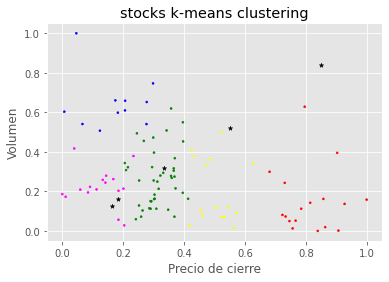

In [ ]:
#%% Plot k-means clustering.
colores=['red','green','blue','yellow','fuchsia']
asignar=[]
for row in labels:
     asignar.append(colores[row])
plt.scatter(x, y, c=asignar, s=4)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='black', s=20) # Marco centroides.
plt.xlabel('Precio de cierre')
plt.ylabel('Volumen')
plt.title('stocks k-means clustering')
plt.show()

**Que podemos inferir???**